# Project Overview:
This notebook implements a Vision Transformer (ViT) model for multi-class skin cancer classification using dermatoscopic images. The goal is to train a deep learning model capable of accurately classifying skin lesions into predefined diagnostic categories.

The workflow includes:

-Dataset loading and preprocessing

-Data augmentation

-Model initialization using a pretrained ViT

-Training and validation

-Model evaluation and testing

In [ ]:
!pip install -q torch torchvision timm scikit-learn albumentations pandas matplotlib tqdm


In [ ]:
from google.colab import files
files.upload()   # ⬅️ choose your kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"binhdiep","key":"8667e2391290a7a95947eeb13dfa30a1"}'}

In [ ]:
!mv "kaggle (17).json" kaggle.json


mv: cannot stat 'kaggle (17).json': No such file or directory


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets list -s ham10000


ref                                                          title                                                   size  lastUpdated                 downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  -----------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
kmader/skin-cancer-mnist-ham10000                            Skin Cancer MNIST: HAM10000                       5582914511  2018-09-20 20:36:13.037000         233012       2195  0.7058824        
surajghuwalewala/ham1000-segmentation-and-classification     Skin cancer: HAM10000                             2781385274  2021-05-27 09:08:46.813000          17106        129  0.9411765        
tschandl/ham10000-lesion-segmentations                       HAM10000 Lesion Segmentations                       10766207  2020-07-02 21:20:22.710000           2232         34  0.875            
nightfury007/ham10000-isi

# Connect to HAM10000 dataset

In [ ]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000 -p /content --unzip


Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
 97% 5.04G/5.20G [00:14<00:00, 515MB/s]
100% 5.20G/5.20G [00:14<00:00, 394MB/s]


In [ ]:
!mkdir -p /content/HAM10000_images
!cp /content/HAM10000_images_part_1/* /content/HAM10000_images/
!cp /content/HAM10000_images_part_2/* /content/HAM10000_images/


Import necessary libraries

In [ ]:
import torch, timm, numpy as np
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import pandas as pd, os

# ==== CONFIG ====
CSV_FILE = "/content/HAM10000_metadata.csv"
IMG_DIR = "/content/HAM10000_images"
OUT_DIR = "/content/outputs"
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10
LR = 3e-5
device = "cuda" if torch.cuda.is_available() else "cpu"
os.makedirs(OUT_DIR, exist_ok=True)
print("Using device:", device)

# ==== LOAD DATA ====
df = pd.read_csv(CSV_FILE)


Using device: cuda


Set Directory Path

In [ ]:
CSV_FILE = "/content/HAM10000_metadata.csv"
IMG_DIR = "/content/HAM10000_images"
OUT_DIR = "/content/outputs"

import os
os.makedirs(OUT_DIR, exist_ok=True)
print("✅ Paths ready")


✅ Paths ready


In [ ]:
import torch, timm, numpy as np
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np


In [ ]:
df = pd.read_csv(CSV_FILE)
print("✅ Metadata shape:", df.shape)
print("✅ Sample columns:", df.columns.tolist())

import os
print("✅ Total images:", len(os.listdir(IMG_DIR)))
df.head()


✅ Metadata shape: (10015, 7)
✅ Sample columns: ['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization']
✅ Total images: 10015


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


# Dataset and Preprocessing
The dataset consists of labeled dermatoscopic images organized into class-specific directories. Images are resized and normalized to match the input requirements of the Vision Transformer.

*Image Parameters*

-Image size: 224 × 224

-Color channels: 3 (RGB)

*Data Augmentation (Training Only)*

-Random resized cropping

-Horizontal flipping

-Vertical flipping

-Brightness and contrast adjustment

-Normalization

Validation and test images are only resized and normalized to ensure unbiased evaluation.

In [ ]:
# ==== CONFIG ====
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
LR = 3e-5
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# ==== PREPARE DATA ====
df['label_str'] = df['dx']
classes = sorted(df['label_str'].unique())
df['label'] = df['label_str'].map({c:i for i,c in enumerate(classes)})

train_df, test_df = train_test_split(df, test_size=0.15, stratify=df['label'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, stratify=train_df['label'], random_state=42)

#remove hair_removal
def remove_hair(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #black-hat filtering
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)

    #threshold
    _, thresh = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)

    #inpaint
    image=cv2.inpaint(image,thresh,1,cv2.INPAINT_TELEA)
    return image

def get_transforms(phase):
    if phase == 'train':
        return A.Compose([
            A.RandomResizedCrop(size=(IMG_SIZE, IMG_SIZE), scale=(0.8, 1.0)),
            A.HorizontalFlip(),
            A.VerticalFlip(p=0.2),
            A.RandomBrightnessContrast(p=0.5),

            A.Normalize(),
            ToTensorV2(),
        ])
    else:
        return A.Compose([
            A.Resize(height=IMG_SIZE, width=IMG_SIZE),
            A.Normalize(),
            ToTensorV2(),
        ])


class SkinDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = np.array(Image.open(os.path.join(self.img_dir, row['image_id'] + '.jpg')).convert('RGB'))
        if self.transform: img = self.transform(image=img)['image']
        label = int(row['label'])
        return img, label

train_loader = DataLoader(SkinDataset(train_df, IMG_DIR, get_transforms('train')), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(SkinDataset(val_df, IMG_DIR, get_transforms('val')), batch_size=BATCH_SIZE)

# ==== MODEL ====
# Adding drop_out rate to the model
model = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=len(classes),drop_rate=0.3,drop_path_rate=0.1).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-2)

# ==== TRAINING ====
best_acc = 0
train_losses, val_accuracies, train_accs = [], [], []  # added train_accs list

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # === Compute Training Accuracy ===
    model.eval()
    train_preds, train_true = [], []
    with torch.no_grad():
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            train_preds.extend(outputs.argmax(1).cpu().numpy())
            train_true.extend(labels.cpu().numpy())
    train_acc = accuracy_score(train_true, train_preds)

    # === Validation ===
    preds, true = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds.extend(outputs.argmax(1).cpu().numpy())
            true.extend(labels.cpu().numpy())
    val_acc = accuracy_score(true, preds)

    # === Log and Save ===
    print(f"Epoch {epoch+1} | Train Loss: {running_loss/len(train_loader):.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    train_losses.append(running_loss / len(train_loader))
    val_accuracies.append(val_acc)
    train_accs.append(train_acc)

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), os.path.join(OUT_DIR, "best_model.pth"))
        print("✅ Saved best model")


# === Save Final Model ===
torch.save(model.state_dict(), os.path.join(OUT_DIR, "final_model.pth"))
print("✅ Final model saved manually!")
print("Training Complete! Best Val Accuracy:", best_acc)

Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch 1/20: 100%|██████████| 240/240 [01:44<00:00,  2.29it/s]


Epoch 1 | Train Loss: 0.8098 | Train Acc: 0.8112 | Val Acc: 0.8157
✅ Saved best model


Epoch 2/20: 100%|██████████| 240/240 [01:43<00:00,  2.32it/s]


Epoch 2 | Train Loss: 0.5452 | Train Acc: 0.8448 | Val Acc: 0.8462
✅ Saved best model


Epoch 3/20: 100%|██████████| 240/240 [01:43<00:00,  2.32it/s]


Epoch 3 | Train Loss: 0.4541 | Train Acc: 0.8772 | Val Acc: 0.8603
✅ Saved best model


Epoch 4/20: 100%|██████████| 240/240 [01:42<00:00,  2.33it/s]


Epoch 4 | Train Loss: 0.3660 | Train Acc: 0.8965 | Val Acc: 0.8697
✅ Saved best model


Epoch 5/20: 100%|██████████| 240/240 [01:43<00:00,  2.32it/s]


Epoch 5 | Train Loss: 0.3142 | Train Acc: 0.9021 | Val Acc: 0.8603


Epoch 6/20: 100%|██████████| 240/240 [01:43<00:00,  2.32it/s]


Epoch 6 | Train Loss: 0.2755 | Train Acc: 0.9264 | Val Acc: 0.8791
✅ Saved best model


Epoch 7/20: 100%|██████████| 240/240 [01:43<00:00,  2.33it/s]


Epoch 7 | Train Loss: 0.2412 | Train Acc: 0.9441 | Val Acc: 0.8885
✅ Saved best model


Epoch 8/20: 100%|██████████| 240/240 [01:43<00:00,  2.31it/s]


Epoch 8 | Train Loss: 0.2121 | Train Acc: 0.9345 | Val Acc: 0.8674


Epoch 9/20: 100%|██████████| 240/240 [01:43<00:00,  2.32it/s]


Epoch 9 | Train Loss: 0.1848 | Train Acc: 0.9663 | Val Acc: 0.8991
✅ Saved best model


Epoch 10/20: 100%|██████████| 240/240 [01:43<00:00,  2.32it/s]


Epoch 10 | Train Loss: 0.1533 | Train Acc: 0.9578 | Val Acc: 0.8850


Epoch 11/20: 100%|██████████| 240/240 [01:43<00:00,  2.31it/s]


Epoch 11 | Train Loss: 0.1478 | Train Acc: 0.9696 | Val Acc: 0.8803


Epoch 12/20: 100%|██████████| 240/240 [01:43<00:00,  2.31it/s]


Epoch 12 | Train Loss: 0.1255 | Train Acc: 0.9570 | Val Acc: 0.8920


Epoch 13/20: 100%|██████████| 240/240 [01:43<00:00,  2.33it/s]


Epoch 13 | Train Loss: 0.1151 | Train Acc: 0.9816 | Val Acc: 0.8967


Epoch 14/20: 100%|██████████| 240/240 [01:43<00:00,  2.32it/s]


Epoch 14 | Train Loss: 0.0985 | Train Acc: 0.9860 | Val Acc: 0.8862


Epoch 15/20: 100%|██████████| 240/240 [01:43<00:00,  2.32it/s]


Epoch 15 | Train Loss: 0.0885 | Train Acc: 0.9883 | Val Acc: 0.9002
✅ Saved best model


Epoch 16/20: 100%|██████████| 240/240 [01:43<00:00,  2.32it/s]


Epoch 16 | Train Loss: 0.0891 | Train Acc: 0.9864 | Val Acc: 0.8944


Epoch 17/20: 100%|██████████| 240/240 [01:43<00:00,  2.32it/s]


Epoch 17 | Train Loss: 0.0912 | Train Acc: 0.9749 | Val Acc: 0.8897


Epoch 18/20: 100%|██████████| 240/240 [01:43<00:00,  2.32it/s]


Epoch 18 | Train Loss: 0.0736 | Train Acc: 0.9829 | Val Acc: 0.8932


Epoch 19/20: 100%|██████████| 240/240 [01:43<00:00,  2.31it/s]


Epoch 19 | Train Loss: 0.0771 | Train Acc: 0.9897 | Val Acc: 0.9026
✅ Saved best model


Epoch 20/20: 100%|██████████| 240/240 [01:43<00:00,  2.32it/s]


Epoch 20 | Train Loss: 0.0596 | Train Acc: 0.9863 | Val Acc: 0.9014
✅ Final model saved manually!
Training Complete! Best Val Accuracy: 0.9025821596244131


Visualize some mis-classified images

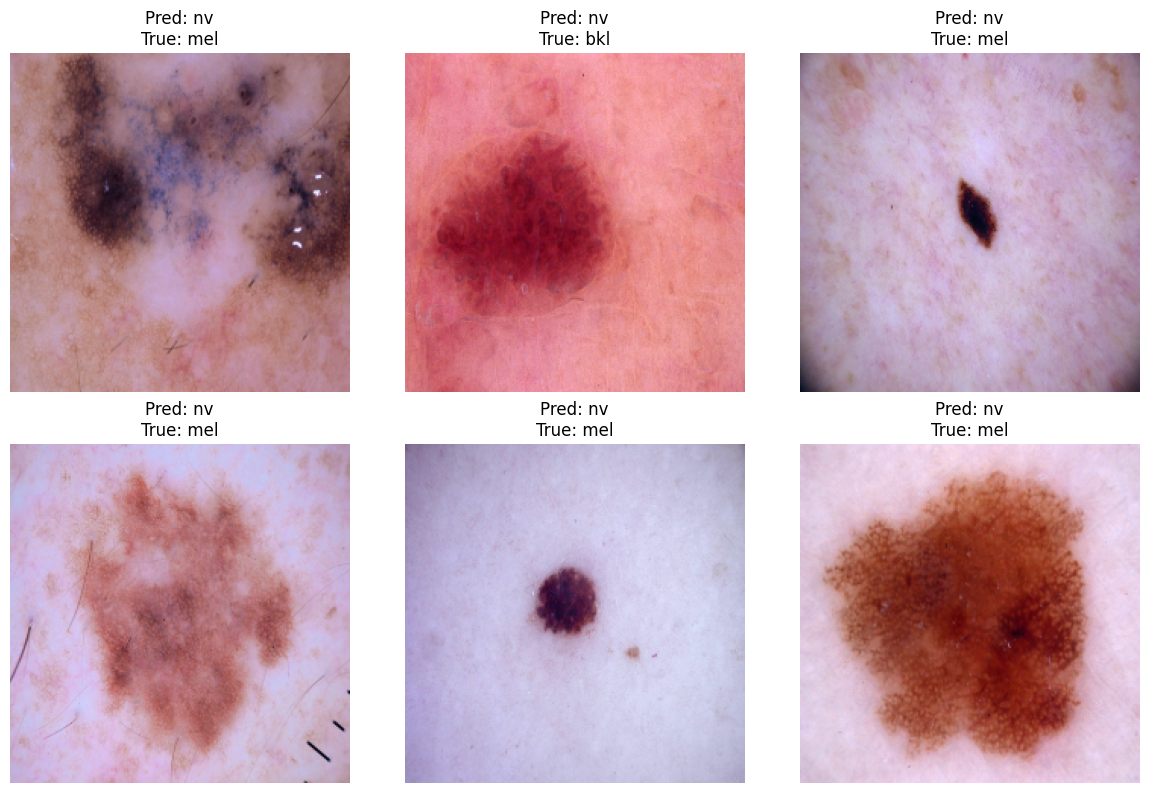

In [ ]:
import matplotlib.pyplot as plt

# ==== LOAD BEST MODEL ====
model.load_state_dict(torch.load(os.path.join(OUT_DIR, "best_model.pth"), map_location=device))
model.eval()

# ==== PREDICT ON VALIDATION SET ====
misclassified = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)
        for i in range(len(preds)):
            if preds[i] != labels[i]:
                misclassified.append((images[i].cpu(), preds[i].cpu().item(), labels[i].cpu().item()))

# ==== SHOW SOME MISCLASSIFIED IMAGES ====
def imshow(img, title):
    img = img.permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min())  # normalize for display
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

# Display first 6 misclassified samples
plt.figure(figsize=(12, 8))
for i, (img, pred, true) in enumerate(misclassified[:6]):
    plt.subplot(2, 3, i + 1)
    imshow(img, f"Pred: {classes[pred]}\nTrue: {classes[true]}")
plt.tight_layout()
plt.show()


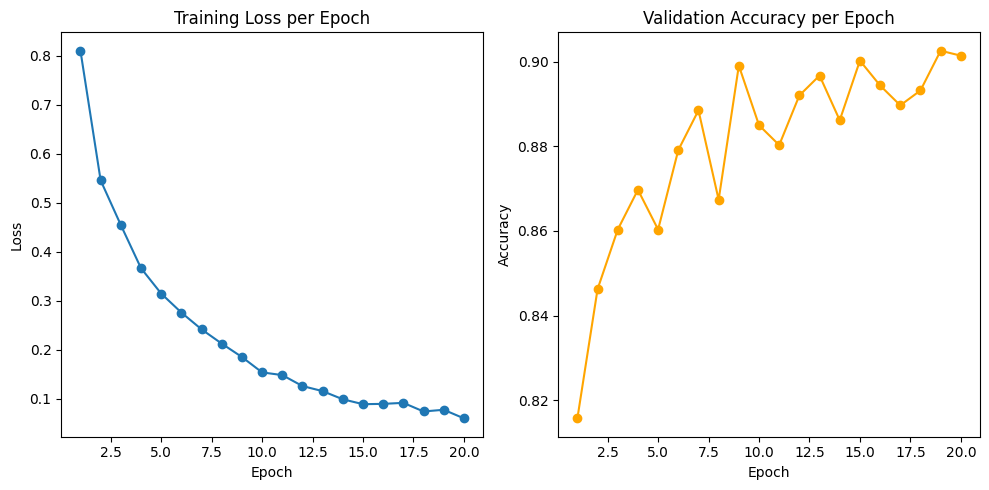

In [ ]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(range(1, EPOCHS+1), train_losses, marker='o')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(range(1, EPOCHS+1), val_accuracies, marker='o', color='orange')
plt.title("Validation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()


# Implement Confusion Matrix

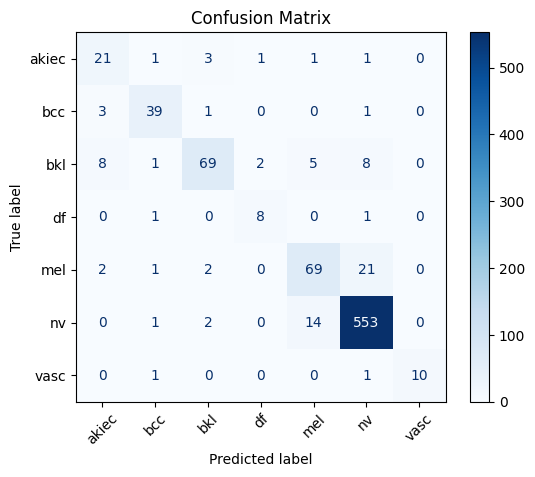


Classification Report:

              precision    recall  f1-score   support

       akiec       0.62      0.75      0.68        28
         bcc       0.87      0.89      0.88        44
         bkl       0.90      0.74      0.81        93
          df       0.73      0.80      0.76        10
         mel       0.78      0.73      0.75        95
          nv       0.94      0.97      0.96       570
        vasc       1.00      0.83      0.91        12

    accuracy                           0.90       852
   macro avg       0.83      0.82      0.82       852
weighted avg       0.90      0.90      0.90       852



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=classes))


# Model Evaluation

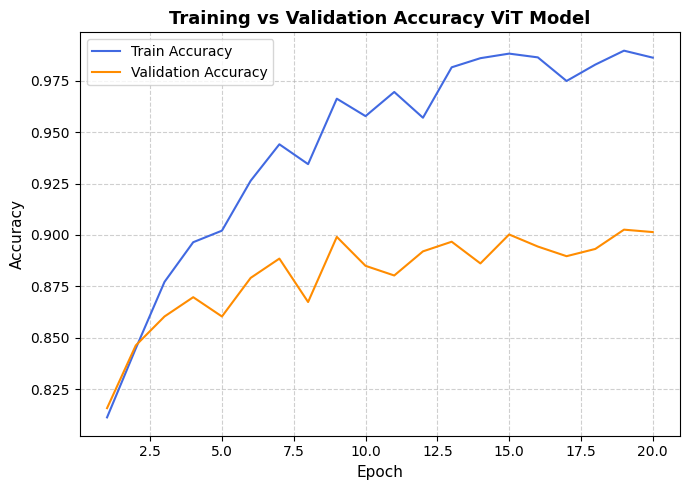

In [ ]:
# === Validation Curve (Training vs Validation Accuracy) ===
import matplotlib.pyplot as plt

epochs = range(1, len(val_accuracies) + 1)

plt.figure(figsize=(7,5))
plt.plot(epochs, train_accs, label='Train Accuracy', color='royalblue')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='darkorange')

plt.title('Training vs Validation Accuracy ViT Model', fontsize=13, weight='bold')
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Accuracy', fontsize=11)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
model = timm.create_model("vit_base_patch16_224", pretrained=False, num_classes=len(classes)).to(device)
model.load_state_dict(torch.load("/content/outputs/best_model.pth", map_location=device))
model.eval()
print("✅ Model loaded successfully for evaluation.")


✅ Model loaded successfully for evaluation.


✅ Loaded best model from /content/outputs/best_model.pth

📊 Training Accuracy: 0.9896


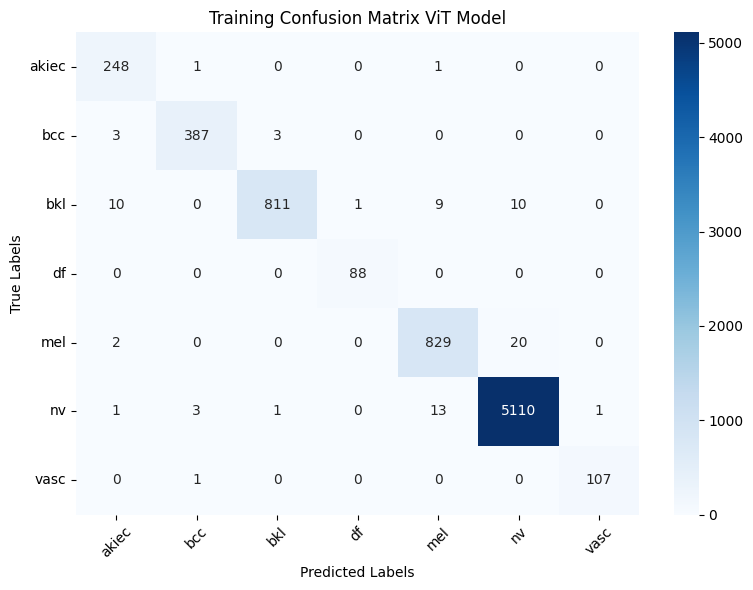

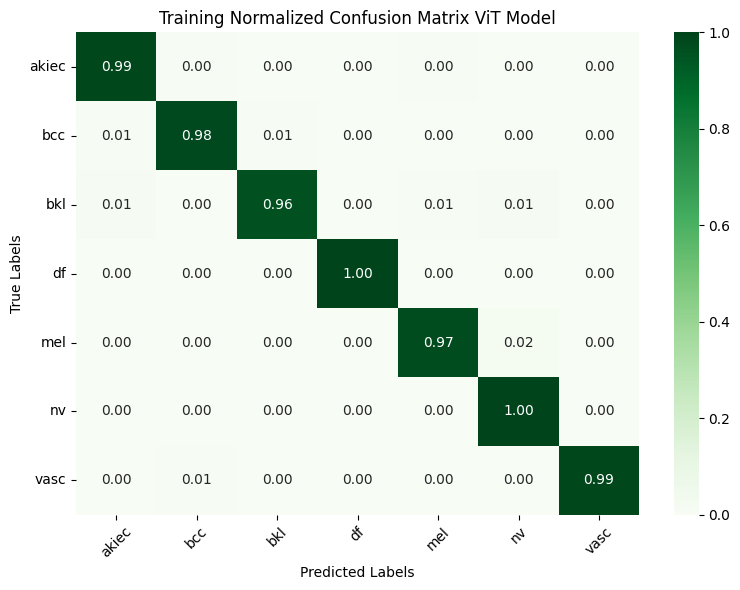


🧾 Training Classification Report:
              precision    recall  f1-score   support

       akiec       0.94      0.99      0.96       250
         bcc       0.99      0.98      0.99       393
         bkl       1.00      0.96      0.98       841
          df       0.99      1.00      0.99        88
         mel       0.97      0.97      0.97       851
          nv       0.99      1.00      1.00      5129
        vasc       0.99      0.99      0.99       108

    accuracy                           0.99      7660
   macro avg       0.98      0.99      0.98      7660
weighted avg       0.99      0.99      0.99      7660


📊 Validation Accuracy: 0.9026


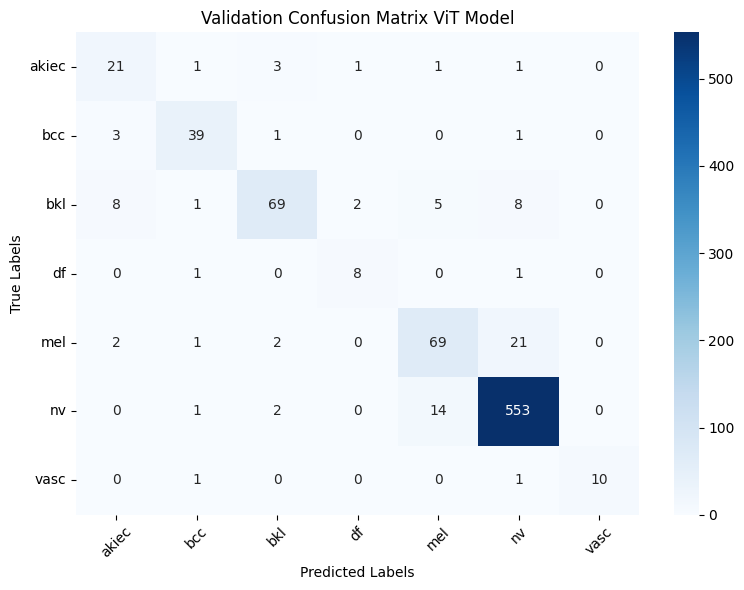

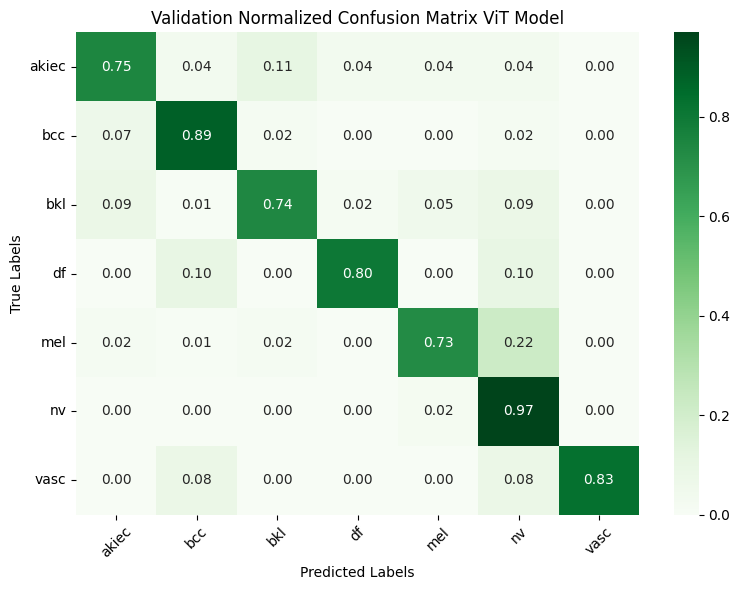


🧾 Validation Classification Report:
              precision    recall  f1-score   support

       akiec       0.62      0.75      0.68        28
         bcc       0.87      0.89      0.88        44
         bkl       0.90      0.74      0.81        93
          df       0.73      0.80      0.76        10
         mel       0.78      0.73      0.75        95
          nv       0.94      0.97      0.96       570
        vasc       1.00      0.83      0.91        12

    accuracy                           0.90       852
   macro avg       0.83      0.82      0.82       852
weighted avg       0.90      0.90      0.90       852


📊 Test Accuracy: 0.9075


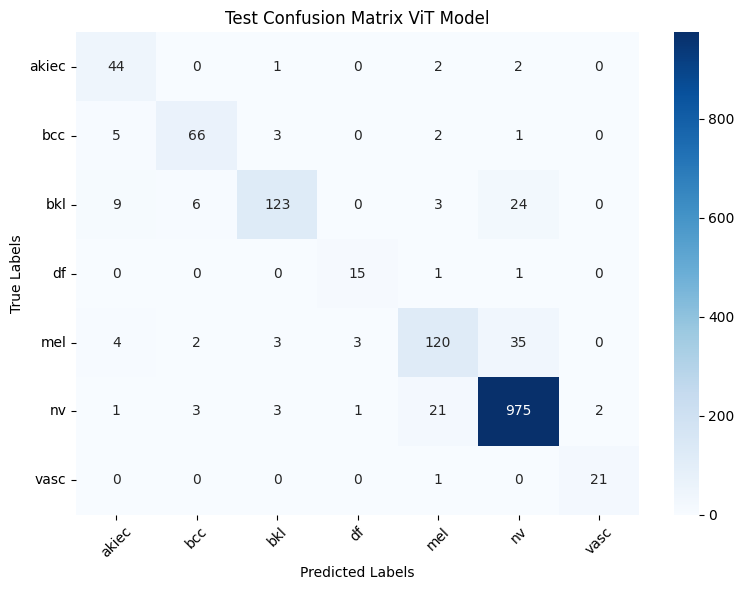

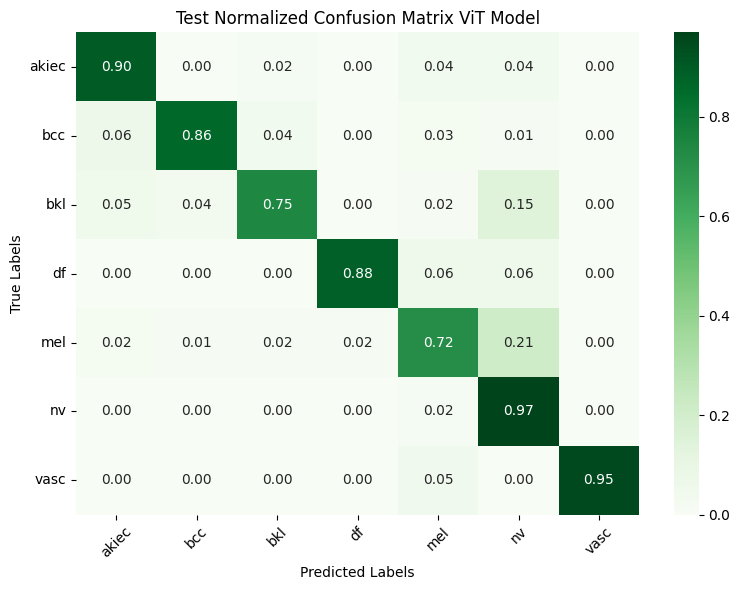


🧾 Test Classification Report:
              precision    recall  f1-score   support

       akiec       0.70      0.90      0.79        49
         bcc       0.86      0.86      0.86        77
         bkl       0.92      0.75      0.83       165
          df       0.79      0.88      0.83        17
         mel       0.80      0.72      0.76       167
          nv       0.94      0.97      0.95      1006
        vasc       0.91      0.95      0.93        22

    accuracy                           0.91      1503
   macro avg       0.85      0.86      0.85      1503
weighted avg       0.91      0.91      0.91      1503



In [ ]:
# ==== EVALUATION FOR TRAIN, VAL, AND TEST SETS ====
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# === Load the best model ===
best_model_path = os.path.join(OUT_DIR, "best_model.pth")
if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    print(f"✅ Loaded best model from {best_model_path}")
else:
    print("⚠️ Best model not found, using current weights")

# === Helper Function for Confusion Matrix & Report ===
def evaluate_model(loader, split_name="Validation"):
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # === Accuracy ===
    acc = accuracy_score(y_true, y_pred)
    print(f"\n📊 {split_name} Accuracy: {acc:.4f}")

    # === Confusion Matrix ===
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"{split_name} Confusion Matrix ViT Model")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # === Normalized Confusion Matrix ===
    plt.figure(figsize=(8, 6))
    cm_norm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Greens",
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"{split_name} Normalized Confusion Matrix ViT Model")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # === Classification Report ===
    print(f"\n🧾 {split_name} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

# === Evaluate on all splits ===
evaluate_model(train_loader, "Training")
evaluate_model(val_loader, "Validation")
evaluate_model(DataLoader(SkinDataset(test_df, IMG_DIR, get_transforms('val')), batch_size=BATCH_SIZE), "Test")

In [ ]:
from torch import nn

# 1) Find the first Conv2d layer
first_conv_name, first_conv = None, None
for name, module in model.named_modules():
    if isinstance(module, nn.Conv2d):
        first_conv_name, first_conv = name, module
        break

print("First Conv layer:", first_conv_name, first_conv)

# 2) Register a forward hook to capture its output
feature_maps = {}

def hook_fn(module, input, output):
    feature_maps['first_conv'] = output.detach().cpu()

hook_handle = first_conv.register_forward_hook(hook_fn)


First Conv layer: patch_embed.proj Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))


In [ ]:
!pip install torchinfo


# Visualizing model architecture details

In [ ]:
from torchinfo import summary

# For ViT base, input is 3×224×224; batch size 1
summary(
    model,
    input_size=(1, 3, 224, 224),
    col_names=("input_size", "output_size", "num_params", "kernel_size"),
    depth=4,   # increase if you want to expand deeper nested blocks
)


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape
VisionTransformer                        [1, 3, 224, 224]          [1, 7]                    152,064                   --
├─PatchEmbed: 1-1                        [1, 3, 224, 224]          [1, 196, 768]             --                        --
│    └─Conv2d: 2-1                       [1, 3, 224, 224]          [1, 768, 14, 14]          590,592                   [16, 16]
│    └─Identity: 2-2                     [1, 196, 768]             [1, 196, 768]             --                        --
├─Dropout: 1-2                           [1, 197, 768]             [1, 197, 768]             --                        --
├─Identity: 1-3                          [1, 197, 768]             [1, 197, 768]             --                        --
├─Identity: 1-4                          [1, 197, 768]             [1, 197, 768]             --                        --
├─Sequen

# Visualize simplified ViT architecture

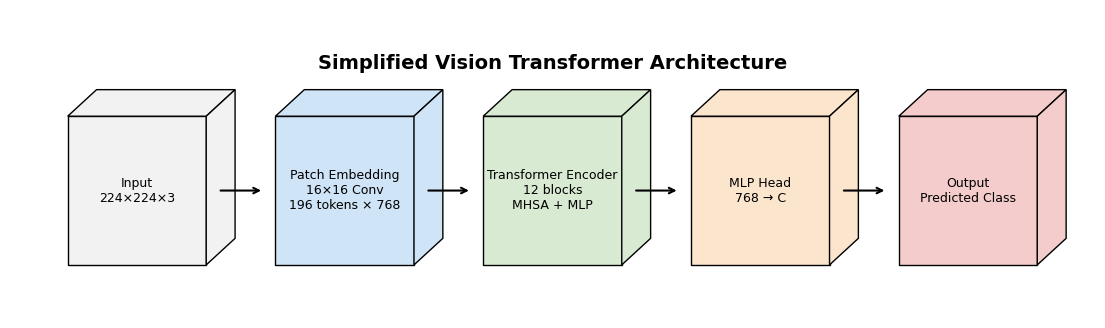

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# ===== Helper: draw a fake 3D block =====
def draw_block(ax, x, y, w, h, d, label, face_color="#DDDDDD"):
    """
    x, y : front-bottom-left corner
    w, h : width, height of front face
    d    : depth offset
    """
    # Front rectangle
    front = [(x, y), (x+w, y), (x+w, y+h), (x, y+h)]
    # Top rectangle
    top = [(x, y+h), (x+d, y+h+d), (x+w+d, y+h+d), (x+w, y+h)]
    # Side rectangle
    side = [(x+w, y), (x+w+d, y+d), (x+w+d, y+h+d), (x+w, y+h)]

    for poly_pts in [front, top, side]:
        poly = Polygon(poly_pts, closed=True,
                       facecolor=face_color, edgecolor="black")
        ax.add_patch(poly)

    # Put text on the front face
    ax.text(
        x + w/2,
        y + h/2,
        label,
        ha="center", va="center",
        fontsize=9
    )

# ===== Create the diagram =====
fig, ax = plt.subplots(figsize=(14, 4))

# Coordinates & sizes
y = 0
h = 2.8
w = 2.4
d = 0.5
gap = 1.2

x0 = 0
x1 = x0 + w + gap
x2 = x1 + w + gap
x3 = x2 + w + gap
x4 = x3 + w + gap

# Block 1: Input
label_input = "Input\n224×224×3"
draw_block(ax, x0, y, w, h, d, label_input, face_color="#F2F2F2")

# Block 2: Patch Embedding
label_patch = (
    "Patch Embedding\n"
    "16×16 Conv\n"
    "196 tokens × 768"
)
draw_block(ax, x1, y, w, h, d, label_patch, face_color="#D0E4F7")

# Block 3: Transformer Encoder
label_encoder = (
    "Transformer Encoder\n"
    "12 blocks\n"
    "MHSA + MLP"
)
draw_block(ax, x2, y, w, h, d, label_encoder, face_color="#D9EAD3")

# Block 4: MLP Head
label_head = (
    "MLP Head\n"
    "768 → C"
)
draw_block(ax, x3, y, w, h, d, label_head, face_color="#FCE5CD")

# Block 5: Output
label_output = "Output\nPredicted Class"
draw_block(ax, x4, y, w, h, d, label_output, face_color="#F4CCCC")

# Arrows between blocks
def arrow_between(x_start, x_end, y_center):
    ax.annotate(
        "",
        xy=(x_end - 0.2, y_center),
        xytext=(x_start + w + 0.2, y_center),
        arrowprops=dict(arrowstyle="->", linewidth=1.5)
    )

y_center = y + h/2
arrow_between(x0, x1, y_center)
arrow_between(x1, x2, y_center)
arrow_between(x2, x3, y_center)
arrow_between(x3, x4, y_center)

# Title
ax.text(
    (x0 + x4 + w) / 2, y + h + 1.0,
    "Simplified Vision Transformer Architecture",
    ha="center", va="center",
    fontsize=14, fontweight="bold"
)

ax.set_xlim(-1, x4 + w + 1)
ax.set_ylim(-1, y + h + 2)
ax.axis("off")

# No tight_layout to avoid margin warnings
plt.show()
